In [1]:
import sys
sys.path.append("./src")
import os
import pandas as pd 
import numpy as np
import json
import glob
import shutil
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import xception

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2
import tensorflow as tf


from model_trans import *


#from tensorflow.keras.applications.xception import preprocess_input


In [2]:
os.path.abspath(os.curdir)

'/home/t6hung/DSC180/DSC180_capstone/Racial_Classification_XAI_Model'

In [22]:
json_path = "./config/age_parameters.json"

with open(json_path) as param:
    data = json.load(param)
    model_param = data["model_param"]
    data_info = data["load_data"]
    integrated = data["integrated_grad"]
param.close()

lr, epochs, batch_size, mapping_path, save_path, log_path = model_param.values()
train_label_path, train_image_path, valid_label_path, valid_image_path, target, size = data_info.values()

In [5]:
img_name = "{}.jpg".format(1)
sample_path = os.path.join(valid_image_path, img_name)
sample_label_df = pd.read_csv(valid_label_path)
sample_label = sample_label_df[sample_label_df["file"].str.contains(img_name)]["race"].values[0]
    

In [19]:
#resnet_v2.preprocess_input(plt.imread(sample_path))

In [24]:
model_param_path = integrated["model_param_path"]
image_path = integrated["image_path"]
label_path = integrated["label_path"]
save_path = integrated["save_path"]
target = integrated["target"]
mapping = integrated["mapping"]
size = integrated["size"]
img_idx = integrated["img_idx"]

In [29]:
with open(mapping) as f:
    data = json.load(f)
f.close()
temp = {val:key for key, val in data.items()}
len(temp)

9

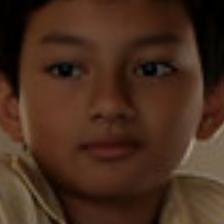

In [8]:

model = keras.models.load_model(model_param_path)
ig = integrated_gradients(model)

img_name = "{}.jpg".format(img_idx)
sample_path = os.path.join(image_path, img_name)
sample_label_df = pd.read_csv(label_path)
sample_label = sample_label_df[sample_label_df["file"].str.contains(img_name)][target].values[0]

sample_image = Image.open(sample_path)
sample_image.save(os.path.join(save_path, "Original_") + str(img_idx)+".png")

#plt.figure(figsize = (5, 5))
#plt.imshow(sample_image.squeeze(), cmap="Greys")
#plt.xticks([],[])
#plt.yticks([],[])
#plt.title("Original image", fontsize=8)
#plt.savefig(os.path.join(save_path, "Original_") + str(img_idx)+".png")

# Generate explanation with respect to each of 10 output channels.

processed_image = resnet_v2.preprocess_input(plt.imread(sample_path)).reshape(-1, size, size, 3)

exs = []
output_prob = model.predict(processed_image).squeeze()
for i in range(1,8):
    exs.append(ig.explain(processed_image.squeeze(), outc=i-1))
exs = np.array(exs)

# Plot them
th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))


fig = plt.subplots(3,3,figsize=(15,15))
for i in range(7):
    ex = exs[i]
    plt.subplot(3,3,i+1)
    plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title("heatmap for age range {} with probability {:.2f}".format(mapping[i],output_prob[i]), 
              fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(save_path,"integrated-viz_") + str(img_idx)+".png")
plt.show()
print("Ground Truth:", sample_label)
print("Predicted:", mapping[np.argmax(output_prob)])

In [9]:
save_path

'./models/race/race_t5.hdf5'

In [ ]:
pd.read_csv(train_label_path)["gender"].nunique()

In [6]:
def create_generator(csv_path, image_path, target, size, batch_size, preprocess_input, is_training):
    
    if is_training:
        horizontal_flip = False
        vertical_flip = False
    else:
        horizontal_flip = True
        vertical_flip = True
    
    df = pd.read_csv(csv_path)
    df["file"] = df["file"].apply(lambda x: os.path.join(image_path, x.split("/")[1]))
    
    imgdatagen = ImageDataGenerator(
        preprocessing_function = xception.preprocess_input,
        horizontal_flip = horizontal_flip, 
        vertical_flip = vertical_flip,
    )
    
    data_generator = imgdatagen.flow_from_dataframe(
        dataframe = df,
        directory = None,
        x_col = "file",
        y_col = target,
        target_size = (size, size),
        batch_size = batch_size,
        save_format = "jpg",
        shuffle = True
    )
    
    with open(mapping_path, "w") as f:
        json.dump(data_generator.class_indices, f)
    f.close()
    
    return data_generator

In [7]:
val = create_generator(valid_label_path, valid_image_path, 
                       target, size, batch_size, densenet.preprocess_input, False)

Found 10954 validated image filenames belonging to 7 classes.


In [8]:
samp = next(iter(val))

In [9]:
samp[0]

array([[[[-0.5372549 , -0.4588235 , -0.64705884],
         [-0.5686275 , -0.49019605, -0.6784314 ],
         [-0.6       , -0.52156866, -0.70980394],
         ...,
         [-0.62352943, -0.70980394, -0.75686276],
         [-0.5529412 , -0.6392157 , -0.6862745 ],
         [-0.42745095, -0.5137255 , -0.56078434]],

        [[-0.56078434, -0.4823529 , -0.67058825],
         [-0.58431375, -0.5058824 , -0.69411767],
         [-0.6156863 , -0.5372549 , -0.7254902 ],
         ...,
         [-0.58431375, -0.67058825, -0.7176471 ],
         [-0.5137255 , -0.6       , -0.64705884],
         [-0.3960784 , -0.4823529 , -0.5294118 ]],

        [[-0.5764706 , -0.5058824 , -0.67058825],
         [-0.6       , -0.5294118 , -0.69411767],
         [-0.6156863 , -0.5372549 , -0.7254902 ],
         ...,
         [-0.54509807, -0.6313726 , -0.6784314 ],
         [-0.5058824 , -0.5921569 , -0.6392157 ],
         [-0.41176468, -0.4980392 , -0.54509807]],

        ...,

        [[ 0.4431373 ,  0.16078436,  0

In [10]:
tr = ResNet50V2(include_top = False, 
                 weights = "imagenet",
                 input_shape = (224, 224, 3))

In [11]:
tr.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
for layer in tr.layers[:14]:
    print(layer.name)

In [ ]:
len(tr.layers)

In [ ]:
model = Sequential()

for layer in tr.layers[:16]:
    model.add(layer)

In [ ]:
len(mod.layers)

In [ ]:
model = OutputModel().make_default_hidden_layers(size)

In [ ]:
size

In [ ]:
from tensorflow.keras import Sequential

tr = ResNet101V2(include_top = False, 
                          weights = "imagenet",
                          input_shape = (200, 200, 3))

In [ ]:
tr.summary()

In [ ]:
model = Sequential()

for layer in tr.layers[:15]:
            layer.trainable = False
            model.add(layer)
            print(layer.name)

In [ ]:
samp